In [1]:
import pickle
import cPickle
import sklearn
import numpy as np
import os
import time
from sklearn.metrics import confusion_matrix

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import lasagne
import theano
from lasagne.utils import floatX
import theano.tensor as T

### Data Preprocessing

In [3]:
f = open('image_dataset_with_features_googlenet.pkl', 'rb')
dataset = cPickle.load(f)
f.close()

In [4]:
np.random.shuffle(dataset)
class_to_row = {}
for i,item in enumerate(dataset):
    class_to_row.setdefault(item["category"],[])
    class_to_row[item['category']].append(i)
    

#### Keeping the categories with > 5000 images

In [10]:
to_keep = []
for key,val in class_to_row.iteritems():
    if len(val) > 5000:
        to_keep.append(key)
dataset = [i for i in dataset if i['category'] in to_keep]
class_to_row = {}
for i,item in enumerate(dataset):
    class_to_row.setdefault(item["category"],[])
    class_to_row[item['category']].append(i)
    
class_to_label = {}
label_to_class = {}
i = 0
for key in class_to_row.keys():
    class_to_label[key] = i
    label_to_class[i] = key
    i += 1


In [128]:
for key,val in class_to_row.iteritems():
    print key, "|", len(val)

Arts, Crafts & Sewing | 19999
Music | 19999
Clothing, Shoes & Jewelry | 19998
Electronics | 19999
Health & Personal Care | 19994
Beauty | 19999
Automotive | 19999
Video Games | 19997
Pet Supplies | 19998
Books | 19999
Grocery & Gourmet Food | 19998
Baby | 19998
Kindle Store | 19999
Sports & Outdoors | 19999
Patio, Lawn & Garden | 19999
Tools & Home Improvement | 19999
Musical Instruments | 19996
Industrial & Scientific | 11748
Software | 8384
Toys & Games | 19999
Cell Phones & Accessories | 19999
Movies & TV | 19999
Office Products | 19999
Home & Kitchen | 19999


#### 80-20 split for Train/Test

In [60]:
for key,val in class_to_row.iteritems():
    length = len(val)
    label = class_to_label[key]
    first = int(.8 * length)
#     second = int(.8 * length)
    for row in val[0: first ]:
        dataset[row]["split"] = "train"
        dataset[row]['label'] = label
    for row in val[first :  ]:
        dataset[row]["split"] = "val"
        dataset[row]['label'] = label
    

In [63]:
train = [i for i in dataset if i['split'] == "train"]
val = [i for i in dataset if i['split'] == "val"]

### Dataset preparation done! Now build softmax classification layer and train!

In [21]:
def get_data_batch(dataset, size):
    for i in xrange(0, len(dataset), size):
        end = i + size
        if end > len(dataset):
            end = len(dataset)
        yield dataset[i:end]

In [42]:
def prep_batch_for_network(batch):
    x_cnn = floatX(np.zeros((len(batch), 1000)))
    true_label = np.zeros((len(batch), 24), dtype='int32')

    for j, item in enumerate(batch):
        x_cnn[j] = item["cnn features"]
        true_label[j][int(item["label"])] = 1
                
    return x_cnn, true_label

In [88]:
l_in = lasagne.layers.InputLayer(shape=(None, 1000))
l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)
l_mid = lasagne.layers.DenseLayer(l_in_drop, num_units=1000, nonlinearity=lasagne.nonlinearities.rectify)
l_mid2 = lasagne.layers.DenseLayer(l_mid, num_units=1000, nonlinearity=lasagne.nonlinearities.rectify)
l_out_drop = lasagne.layers.DropoutLayer(l_mid2, p=0.5)
l_out = lasagne.layers.DenseLayer(l_out_drop, num_units=24, nonlinearity=lasagne.nonlinearities.softmax)

In [89]:
x_cnn_sym = T.matrix()
y_gt = T.imatrix()

prediction = lasagne.layers.get_output(l_out, {l_in : x_cnn_sym})
loss = lasagne.objectives.categorical_crossentropy(prediction, y_gt)
loss = loss.mean()

params = lasagne.layers.get_all_params(l_out, trainable=True)
updates = lasagne.updates.adam(
        loss, params, learning_rate=.001)

train_fn = theano.function([x_cnn_sym, y_gt], loss, updates=updates)

test_acc = T.mean(T.eq(T.argmax(prediction, axis=1), T.argmax(y_gt, axis=1)),
                  dtype=theano.config.floatX)
val_fn = theano.function([x_cnn_sym, y_gt], [loss, test_acc])

In [95]:
pred = lasagne.layers.get_output(l_out, {l_in : x_cnn_sym})
get_pred = theano.function([x_cnn_sym], pred)

In [90]:
BATCH_SIZE = 3000
EPOCHS = 10

In [ ]:
for epoch in range(EPOCHS):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    np.random.shuffle(train)
    train_err = 0
    train_batches = 0
    for batch in get_data_batch(train, BATCH_SIZE) :
        inputs, targets = prep_batch_for_network(batch)
        train_err += train_fn(inputs, targets)
        train_batches += 1
        
        
    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in get_data_batch(val, len(val)):
        inputs, targets = prep_batch_for_network(batch)
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1
        
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, EPOCHS, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))


In [93]:
param_values = lasagne.layers.get_all_param_values(l_out)
d = {'param values': param_values,
     'class_to_label': class_to_label,
     'label_to_class': label_to_class,
    }
cPickle.dump(d, open('amz_trained_googlenet.pkl','wb'), protocol=pickle.HIGHEST_PROTOCOL)

### Get predictions

In [94]:
y_true = [i["label"] for i in val]
x_cnn = floatX(np.zeros((len(val), 1000)))

for j, item in enumerate(val):
    x_cnn[j] = item["cnn features"]

y_pred = get_pred(x_cnn)
labels = [label_to_class[i] for i in xrange(24)]
y_pred = [np.argmax(i) for i in y_pred]

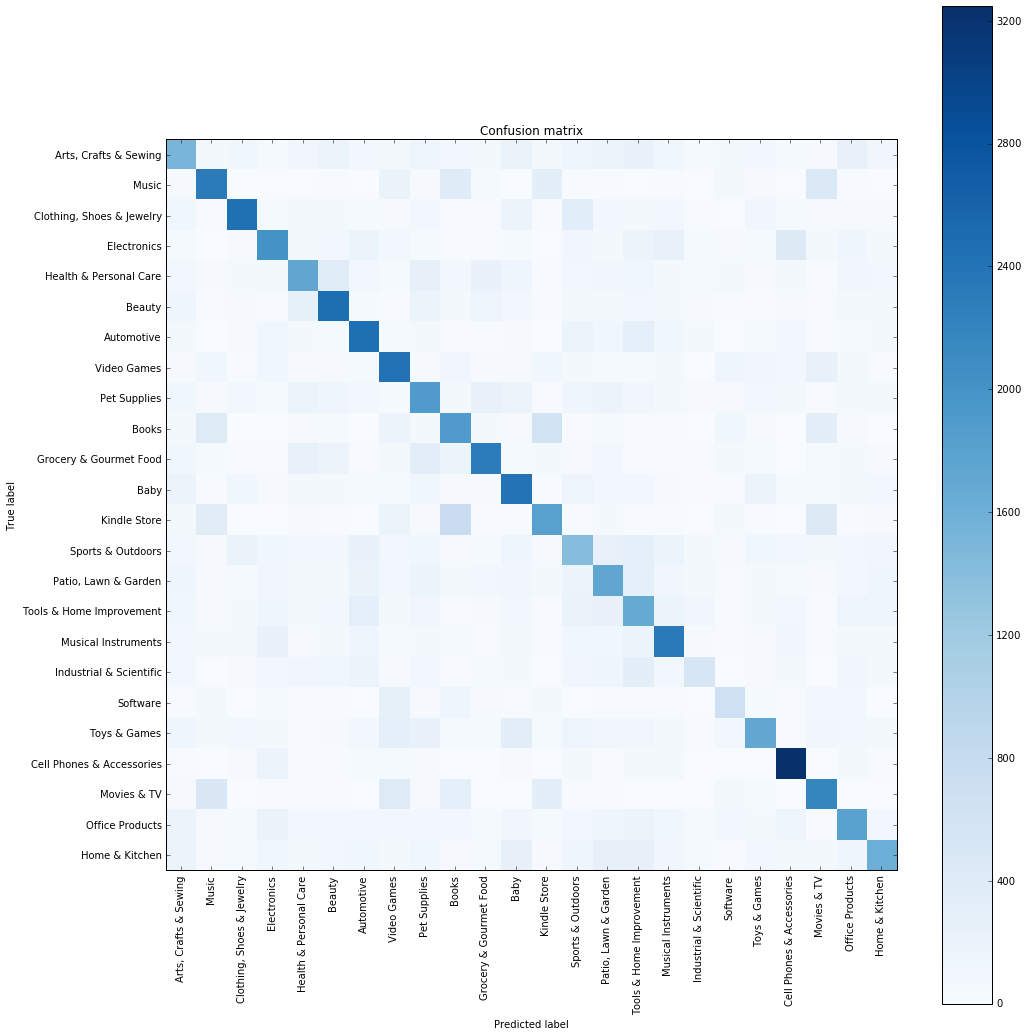

In [113]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
# print('Confusion matrix, without normalization')
# print(cm)
plt.figure(figsize=(15,15))
plot_confusion_matrix(cm)


#### Dump the model

In [114]:
cPickle.dump(get_pred, open('prediction_model.pkl','wb'), protocol=pickle.HIGHEST_PROTOCOL)


In [115]:
cPickle.dump(label_to_class, open('class_dict.pkl','wb'), protocol=pickle.HIGHEST_PROTOCOL)